In [ ]:
#---------------------------------
#  1. Load data and tuned model
#---------------------------------

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

from sklearn.metrics import mean_squared_error, mean_absolute_error

RANDOM_SEED = 42  

In [ ]:


DATA_PATH  = "euro_final_dataset_v2_filtered.csv" 
OUTPUT_DIR = "training_results"
MODEL_PATH = os.path.join(OUTPUT_DIR, "best_random_forest_tuned.joblib")

df = pd.read_csv(DATA_PATH)

for col in ["era5_precip", "rain_7day_avg", "wind_speed"]:
    df[col] = df[col].clip(lower=0)

df["era5_precip_log1p"]   = np.log1p(df["era5_precip"])
df["rain_7day_avg_log1p"] = np.log1p(df["rain_7day_avg"])
df["wind_speed_log1p"]    = np.log1p(df["wind_speed"])

FEATURES = [
    "latitude", "longitude", "elevation",
    "ndvi_local", "ndvi_global",
    "perc_urban", "perc_suburban", "perc_forest",
    "era5_u10", "era5_v10", "wind_speed", "wind_speed_log1p",
    "era5_precip", "era5_precip_log1p",
    "rain_7day_avg", "rain_7day_avg_log1p",
    "sin_day", "cos_day",
]
TARGET= "delta_temp" 

X = df[FEATURES].values
y = df[TARGET].values

rf = joblib.load(MODEL_PATH)
print("Loaded model:", rf)

#------------------------------------------------------
# 2. Predict bias and corrected Tmax for all rows
#------------------------------------------------------

df["delta_obs"]= df[TARGET]
df["delta_pred"] = rf.predict(X)
df["TX_corr"]  = df["era5_temp_max"] + df["delta_pred"]


Loaded model: RandomForestRegressor(max_depth=30, max_features=0.5, min_samples_leaf=2,
                      n_estimators=200, n_jobs=-1, random_state=42)


c:\Users\drugm\anaconda3\envs\genhack\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
#-------------------------------------------------------------
# 3. Quantify how bias depends on NDVI and urban fraction
#-------------------------------------------------------------

df["ndvi_q"]=pd.qcut(df["ndvi_local"], 4,
                       labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"])

ndvi_stats = (
    df.groupby("ndvi_q")[["delta_obs", "delta_pred"]]
      .agg(["mean", "std", "count"])
)
print("\nBias vs local NDVI quartiles (station - ERA5):")
print(ndvi_stats.round(3))

bins = [0, 0.05, 0.25, 0.5, 0.75, 1.0]
labels = ["0-5%", "5-25%", "25-50%", "50-75%", ">75%"]
df["urban_bin"] = pd.cut(df["perc_urban"], bins=bins,
                         labels=labels, include_lowest=True)

urban_stats = (
    df.groupby("urban_bin")[["delta_obs", "delta_pred"]]
      .agg(["mean", "std", "count"])
)
print("\nBias vs urban fraction bins (station - ERA5):")
print(urban_stats.round(3))

ndvi_urban_stats = (
    df.groupby(["ndvi_q", "urban_bin"])[["delta_obs", "delta_pred"]]
      .mean()
      .reset_index()
)
os.makedirs(OUTPUT_DIR, exist_ok=True)
ndvi_urban_path = os.path.join(OUTPUT_DIR, "bias_by_ndvi_urban.csv")
ndvi_urban_stats.to_csv(ndvi_urban_path, index=False)
print("\nSaved detailed NDVI x urban bias table to:", ndvi_urban_path)


C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\925046893.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ndvi_q")[["delta_obs", "delta_pred"]]
C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\925046893.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("urban_bin")[["delta_obs", "delta_pred"]]



Bias vs local NDVI quartiles (station - ERA5):
          delta_obs                delta_pred               
               mean    std   count       mean    std   count
ndvi_q                                                      
Q1 (low)      1.370  2.166  763098      1.370  1.825  763098
Q2            1.404  2.375  759704      1.335  2.015  759704
Q3            1.671  2.696  753986      1.649  2.354  753986
Q4 (high)     1.824  2.983  756951      1.840  2.652  756951

Bias vs urban fraction bins (station - ERA5):
          delta_obs                delta_pred               
               mean    std   count       mean    std   count
urban_bin                                                   
0–5%          1.978  3.095  816287      1.927  2.790  816287
5–25%         1.759  2.755  930574      1.761  2.396  930574
25–50%        1.049  2.143  700588      1.044  1.805  700588
50–75%        1.252  1.754  339918      1.235  1.308  339918
>75%          1.382  1.616  246372      1.352  1.14

C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\925046893.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["ndvi_q", "urban_bin"])[["delta_obs", "delta_pred"]]


C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\926156641.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("ndvi_q")[["delta_obs", "delta_pred"]]
C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\926156641.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("urban_bin")[["delta_obs", "delta_pred"]]


Saved plots to training_results/.


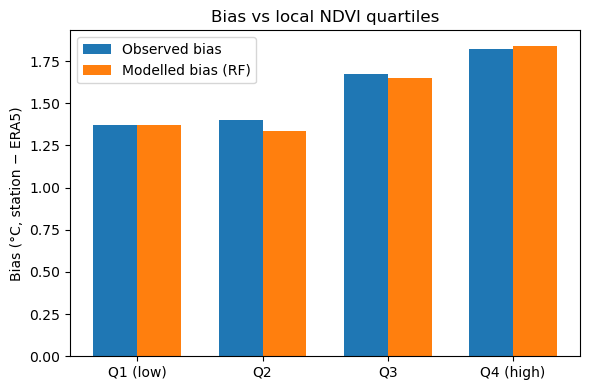

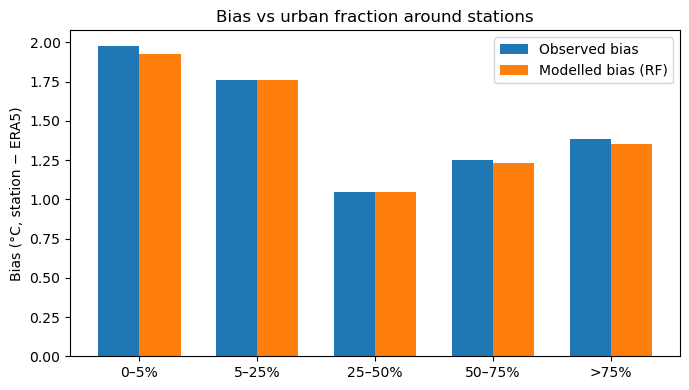

In [ ]:
#----------------------------------------------
# 4. Create plots
#----------------------------------------------

ndvi_mean=(
    df.groupby("ndvi_q")[["delta_obs", "delta_pred"]]
      .mean()
      .reset_index()
)

plt.figure(figsize=(6,4))
x = np.arange(len(ndvi_mean))
width = 0.35
plt.bar(x - width/2, ndvi_mean["delta_obs"], width, label="Observed bias")
plt.bar(x + width/2, ndvi_mean["delta_pred"], width, label="Modelled bias (RF)")
plt.xticks(x, ndvi_mean["ndvi_q"])
plt.ylabel("Bias (°C, station − ERA5)")
plt.title("Bias vs local NDVI quartiles")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "bias_vs_ndvi_quartiles.png"), dpi=200)

urban_mean=(
    df.groupby("urban_bin")[["delta_obs", "delta_pred"]]
      .mean()
      .reset_index()
)

plt.figure(figsize=(7,4))
x = np.arange(len(urban_mean))
plt.bar(x - width/2, urban_mean["delta_obs"], width, label="Observed bias")
plt.bar(x + width/2, urban_mean["delta_pred"], width, label="Modelled bias (RF)")
plt.xticks(x, urban_mean["urban_bin"])
plt.ylabel("Bias (°C, station − ERA5)")
plt.title("Bias vs urban fraction around stations")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "bias_vs_urban_fraction.png"), dpi=200)

print("Saved plots to training_results/.")


In [ ]:
# ----------------------------------------------
# 5. Partial dependence plots for key features
# ----------------------------------------------

def summarize_pd(feature_name, grid_values=None):

    feat_index = FEATURES.index(feature_name)

    pd_result = partial_dependence(
        rf,
        X,   
        features=[feat_index],
        grid_resolution=50, 
        kind="average",
    )
    pd_values = pd_result["average"][0]   
    grid      = pd_result["grid_values"][0] 

    delta_min = float(pd_values.min())
    delta_max = float(pd_values.max())
    effect    = delta_max - delta_min

    print(f"\n=== {feature_name} ===")
    print(f"Feature range in grid: {grid[0]:.2f} → {grid[-1]:.2f}")
    print(f"Predicted delta range: {delta_min:.2f} → {delta_max:.2f} °C")
    print(f"Average effect size  : {effect:.2f} °C (change in predicted bias)")
    return grid, pd_values

grid_elev, pd_elev= summarize_pd("elevation")

grid_ndvi, pd_ndvi = summarize_pd("ndvi_local")



=== elevation ===
Feature range in grid: 4.00 → 1371.00
Predicted delta range: -0.10 → 2.14 °C
Average effect size  : 2.24 °C (change in predicted bias)

=== ndvi_local ===
Feature range in grid: 0.13 → 0.74
Predicted delta range: 1.51 → 1.74 °C
Average effect size  : 0.23 °C (change in predicted bias)


In [ ]:


stations = df["STAID"].values
unique_stations = np.unique(stations)

rng = np.random.RandomState(RANDOM_SEED)
rng.shuffle(unique_stations)

n_stations = len(unique_stations)
n_train = int(0.70 * n_stations)
n_val = int(0.15 * n_stations)
train_stations = unique_stations[:n_train]
val_stations = unique_stations[n_train:n_train + n_val]
test_stations = unique_stations[n_train + n_val:]

def station_mask(sta_list):
    return np.isin(stations, sta_list)

train_mask = station_mask(train_stations)
val_mask   = station_mask(val_stations)
test_mask  = station_mask(test_stations)

print(f"Total stations: {n_stations}")
print(f"Train stations: {len(train_stations)}")
print(f"Val stations  : {len(val_stations)}")
print(f"Test stations : {len(test_stations)}")

delta_obs_test = df.loc[test_mask, "delta_obs"].values
delta_pred_test = df.loc[test_mask, "delta_pred"].values
delta_corr_test = delta_obs_test - delta_pred_test 

zeros = np.zeros_like(delta_obs_test)

def metrics(y_err, label):
    rmse = np.sqrt(mean_squared_error(zeros, y_err))
    mae  = mean_absolute_error(zeros, y_err)
    bias = float(y_err.mean()) 
    return rmse, mae, bias

rmse_raw,  mae_raw,  bias_raw  = metrics(delta_obs_test,  "ERA5 raw")
rmse_corr, mae_corr, bias_corr = metrics(delta_corr_test, "ERA5 + RF correction")

metrics_df = pd.DataFrame({
    "model": ["ERA5 raw", "ERA5 + RF correction"],
    "rmse":  [rmse_raw, rmse_corr],
    "mae":   [mae_raw,  mae_corr],
    "bias":  [bias_raw, bias_corr],
})

print("\nTest-set error metrics (bias defined as station − model, in °C):")
print(metrics_df.round(3))


Total stations: 1891
Train stations: 1323
Val stations  : 283
Test stations : 285

Test-set error metrics (bias defined as station − model, in °C):
                  model   rmse    mae   bias
0              ERA5 raw  3.008  2.285  1.715
1  ERA5 + RF correction  1.938  1.256  0.117


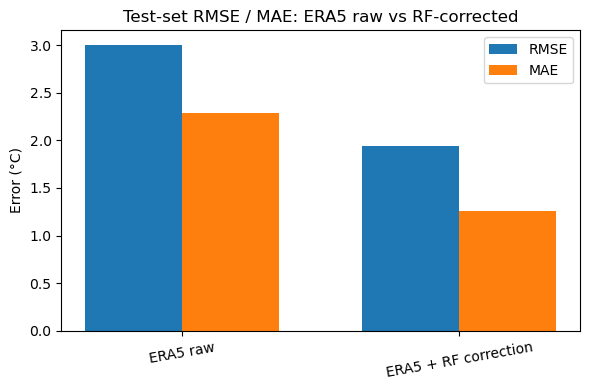

In [ ]:
plt.figure(figsize=(6,4))
x = np.arange(len(metrics_df))
width = 0.35

plt.bar(x - width/2, metrics_df["rmse"], width, label="RMSE")
plt.bar(x + width/2, metrics_df["mae"],  width, label="MAE")

plt.xticks(x, metrics_df["model"], rotation=10)
plt.ylabel("Error (°C)")
plt.title("Test-set RMSE / MAE: ERA5 raw vs RF-corrected")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_raw_vs_corrected_test.png"), dpi=200)
plt.show()


C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\906064455.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("ndvi_q")[["delta_obs", "delta_corr"]]
C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\906064455.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("urban_bin")[["delta_obs", "delta_corr"]]
C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\906064455.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 


Bias vs local NDVI quartiles (TEST, station − model, °C):
          delta_obs                delta_corr               
               mean    std   count       mean    std   count
ndvi_q                                                      
Q1 (low)      1.568  1.813  118624      0.012  1.406  118624
Q2            1.757  2.389  118073      0.399  2.165  118073
Q3            1.736  2.539  119306      0.174  2.131  119306
Q4 (high)     1.802  2.998  116636     -0.119  1.902  116636

Bias vs urban fraction bins (TEST, station − model, °C):
          delta_obs                delta_corr               
               mean    std   count       mean    std   count
urban_bin                                                   
0–5%          2.475  2.764  125515      0.333  2.217  125515
5–25%         1.669  2.815  130886     -0.018  2.335  130886
25–50%        1.078  2.051  120037      0.026  1.457  120037
50–75%        1.531  1.709   60861      0.099  1.345   60861
>75%          1.670  1.528   

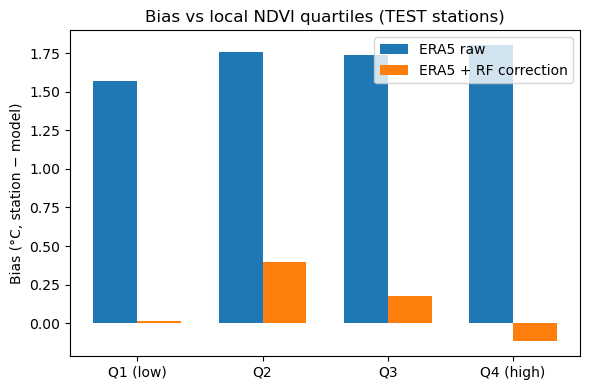

C:\Users\drugm\AppData\Local\Temp\ipykernel_51240\906064455.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("urban_bin")[["delta_obs", "delta_corr"]]


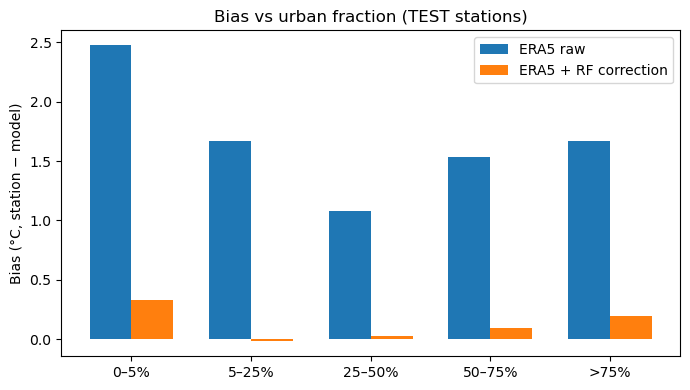

In [ ]:
df["delta_corr"] = df["delta_obs"] - df["delta_pred"]

df_test = df.loc[test_mask].copy()

df_test["ndvi_q"] = pd.qcut(
    df_test["ndvi_local"],
    4,
    labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
)

bins = [0, 0.05, 0.25, 0.5, 0.75, 1.0]
labels = ["0–5%", "5–25%", "25–50%", "50–75%", ">75%"]
df_test["urban_bin"] = pd.cut(
    df_test["perc_urban"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

ndvi_stats_corr = (
    df_test.groupby("ndvi_q")[["delta_obs", "delta_corr"]]
    .agg(["mean", "std", "count"])
)
urban_stats_corr = (
    df_test.groupby("urban_bin")[["delta_obs", "delta_corr"]]
    .agg(["mean", "std", "count"])
)

print("\nBias vs local NDVI quartiles (TEST, station − model, °C):")
print(ndvi_stats_corr.round(3))

print("\nBias vs urban fraction bins (TEST, station − model, °C):")
print(urban_stats_corr.round(3))


ndvi_mean_corr = (
    df_test.groupby("ndvi_q")[["delta_obs", "delta_corr"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
x = np.arange(len(ndvi_mean_corr))
width = 0.35
plt.bar(x - width/2, ndvi_mean_corr["delta_obs"], width, label="ERA5 raw")
plt.bar(x + width/2, ndvi_mean_corr["delta_corr"], width, label="ERA5 + RF correction")
plt.xticks(x, ndvi_mean_corr["ndvi_q"])
plt.ylabel("Bias (°C, station − model)")
plt.title("Bias vs local NDVI quartiles (TEST stations)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "bias_vs_ndvi_quartiles_raw_vs_corrected_test.png"), dpi=200)
plt.show()

# Urban
urban_mean_corr = (
    df_test.groupby("urban_bin")[["delta_obs", "delta_corr"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7,4))
x = np.arange(len(urban_mean_corr))
plt.bar(x - width/2, urban_mean_corr["delta_obs"], width, label="ERA5 raw")
plt.bar(x + width/2, urban_mean_corr["delta_corr"], width, label="ERA5 + RF correction")
plt.xticks(x, urban_mean_corr["urban_bin"])
plt.ylabel("Bias (°C, station − model)")
plt.title("Bias vs urban fraction (TEST stations)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "bias_vs_urban_raw_vs_corrected_test.png"), dpi=200)
plt.show()
